In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import os
#import graphviz
import matplotlib.pyplot as plt
import pickle
import timeit

In [2]:
%matplotlib inline
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [3]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
DATA_PATH = "~chandler.mccann/Downloads/"
#DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [4]:
df = pd.read_csv(INPUT_FILE)

In [5]:
sl = df.loc[df.country_name=='Liberia']

In [6]:
sl.shape

(14028, 40)

In [7]:
features = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

# Modeling

In [8]:
#start_time = timeit.default_timer()

pred_cols = features

#create a copy of the dataframe to label encode
df2 = sl.copy()
df2=df2[pred_cols]

In [9]:
#we can't have any null target values
len(df2[df2.status_binary.isna()==True])


0

In [10]:
#eliminate null target values
df2 = df2[pd.notnull(df['status_binary'])]

In [11]:
#check
len(df2[df2.status_binary.isna()==True])


0

In [12]:
X = df2[df2.columns[:-1]] 
Y= df2.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    #lb.fit(list(X[col].fillna('___MISSING___').drop_duplicates().values) + ['___MISSING___'])
    
    #X2[col] = lb.transform(X2[col].fillna('___MISSING___'))
    X2[col]= lb.fit_transform(X[col].fillna('__MISSING__'))

In [13]:
#60/20/20 Train/Test/Holdout Split
SEED=7
X_train, X_test_and_holdout, y_train, y_test_and_holdout = sk.model_selection.train_test_split(X2, Y,
                                                                                        test_size=.4,
                                                                                        stratify=Y,
                                                                                        random_state=SEED)
X_test, X_holdout, y_test, y_holdout = sk.model_selection.train_test_split(X_test_and_holdout,
                                                                    y_test_and_holdout,
                                                                    test_size=.5, 
                                                                    stratify= y_test_and_holdout,
                                                                    random_state=SEED)

In [16]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[1000, 2500]}
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                        colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
model_inner.fit(X_train, y_train )

beggining inner CV...


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7], 'n_estimators': [1000, 2500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [17]:
print('model fit for inner CV for Zimbabwe')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Zimbabwe
Shape of input params=  (8416, 14)
Best searched parameters on inner CV {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Best grid score on inner CV 0.815470532319
Accuracy for inner nested_cv model : 0.8239
AUC Score (test) for inner_nested cv_model: 0.816574
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.05,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [18]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_holdout)

#Print model report:
print("\nModel Report")
print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Number of trees determined by early stopping and in final model 1000
Accuracy for outer nested_cv model on training data: 0.8497
AUC Score (Train) for outer nested_cv model: 0.893839
AUC Score (Test) for outer nested_cv model: 0.816574
AUC Score (Holdout) for outer nested_cv model: 0.809096
Accuracy for outer nested_cv model on holdout data: 0.8115


# not super stable across train to holdout. Why?

In [19]:
def get_nested_cv_preds(model, X, Y):
    """args: classification model object, fully numeric/ encoded X, target columns
       returns: array of 1) binary classification predictions, 2) probabilities of class membership"""
    #shuffle is necessary. Define same stratified k-fold as before
    #ToDo - fix hard coding of random state, splits, 
    skf= model_selection.StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    
    print('full data AUC- CV score', sk.model_selection.cross_val_score(model, X, y=Y, scoring='roc_auc',cv=skf))
    cv_results_preds = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf )
    cv_results_probs = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf, method ='predict_proba')
    
    print("Accuracy full-data : %.4g" % metrics.accuracy_score(Y, cv_results_preds))
    print("AUC Score full-data: %f" % metrics.roc_auc_score(Y, cv_results_probs[:,1]))
    
    return cv_results_preds, cv_results_probs

In [20]:
get_nested_cv_preds(model_outer,X2,Y)

full data AUC- CV score [ 0.82340122  0.80774739  0.82841962  0.82366042  0.81670698]
Accuracy full-data : 0.8191
AUC Score full-data: 0.819797


(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([[ 0.72893918,  0.27106079],
        [ 0.83218473,  0.16781528],
        [ 0.60314655,  0.39685348],
        ..., 
        [ 0.99763334,  0.00236667],
        [ 0.99763334,  0.00236667],
        [ 0.99656135,  0.00343865]], dtype=float32))

In [21]:
def save_model(model, country):
    filename = '{}_pickle.sav'.format(country)
    pickle.dump(model, open(filename, 'wb'))
    print('saved as', filename)

In [24]:
name = sl.country_name.unique()[0]
save_model(model_outer, name)

saved as Liberia_pickle.sav


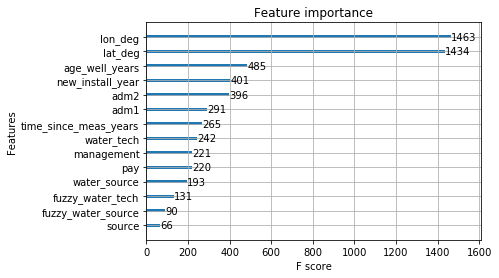

In [25]:
xgb.plot_importance(model_outer)

# we now how of our early stopped, cross-validated model. We now need to identify the ideal prediction threshold

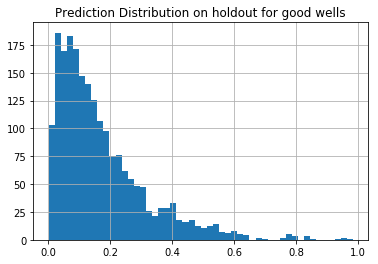

In [26]:
pd.DataFrame(dholdout_predprob[y_holdout==0]).hist(bins=50)
plt.title('Prediction Distribution on holdout for good wells')


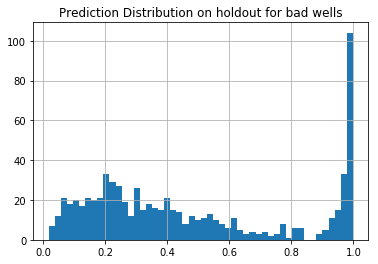

In [27]:
pd.DataFrame(dholdout_predprob[y_holdout==1]).hist(bins=50)
plt.title('Prediction Distribution on holdout for bad wells')


(array([ 0.50796031,  1.07236065,  1.52388093,  1.29812079,  1.24168076,
         1.41100086,  1.4674409 ,  2.20116134,  2.03184124,  1.58032096,
         1.24168076,  1.52388093,  1.07236065,  1.24168076,  1.18524072,
         1.29812079,  1.01592062,  0.84660052,  0.84660052,  0.62084038,
         0.90304055,  0.62084038,  0.67728041,  0.50796031,  0.67728041,
         0.33864021,  0.1693201 ,  0.28220017,  0.28220017,  0.05644003,
         0.56440034,  0.11288007,  0.50796031,  0.1693201 ,  0.        ,
         0.1693201 ,  0.45152028,  0.73372045,  1.74964107,  6.547044  ]),
 array([ 0.01685654,  0.0413966 ,  0.06593665,  0.09047671,  0.11501676,
         0.13955682,  0.16409687,  0.18863693,  0.21317698,  0.23771704,
         0.26225709,  0.28679715,  0.3113372 ,  0.33587726,  0.36041731,
         0.38495737,  0.40949742,  0.43403748,  0.45857753,  0.48311759,
         0.50765764,  0.5321977 ,  0.55673775,  0.58127781,  0.60581786,
         0.63035792,  0.65489797,  0.67943803,  0

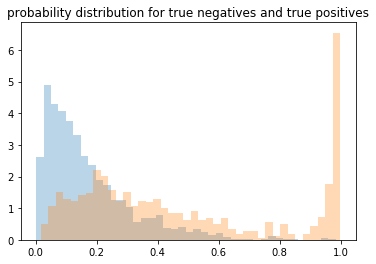

In [28]:

x1 = dholdout_predprob[y_holdout==0]
x2 = dholdout_predprob[y_holdout==1]


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.title('probability distribution for true negatives and true positives')
plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)


### Some separation, will need to adjust the threshold

In [30]:
#try a bunch of different prediction thresholds < 0.5 and see which one maximizes recall and F1 score
import numpy as np
d = dict()
for i in np.linspace(0,0.5, num=20):
    best = 0
    test = np.where(dtest_predprob > i, 1,0)
    recall = metrics.recall_score(y_test, test)
    precision = metrics.precision_score(y_test, test)
    f_score = metrics.f1_score(y_test, test, average='binary')
    d[i]=recall, precision, f_score
    
frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
frame.columns=(['recall','precision', 'f1_score'])
frame[frame.recall>0.7]

,recall,precision,f1_score
0.000000,1.000000,0.256949,0.408846
0.026316,0.995839,0.270128,0.424978
0.052632,0.977809,0.295226,0.453522
0.078947,0.952843,0.318646,0.477581
0.105263,0.926491,0.349372,0.507406
0.131579,0.889043,0.374854,0.527355
0.157895,0.836338,0.403614,0.544470
0.184211,0.793343,0.433333,0.560510
0.210526,0.736477,0.464161,0.569437
0.236842,0.707351,0.508982,0.591991


In [32]:
#try a bunch of different prediction thresholds < 0.5 and see which one maximizes recall and F1 score
import numpy as np
d = dict()
for i in np.linspace(0,0.5, num=20):
    best = 0
    test = np.where(dholdout_predprob > i, 1,0)
    recall = metrics.recall_score(y_holdout, test)
    precision = metrics.precision_score(y_holdout, test)
    f_score = metrics.f1_score(y_holdout, test, average='binary')
    d[i]=recall, precision, f_score
    
frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
frame.columns=(['recall','precision', 'f1_score'])
frame[frame.recall>0.6]

,recall,precision,f1_score
0.000000,1.000000,0.257306,0.409297
0.026316,0.997230,0.270270,0.425281
0.052632,0.977839,0.295521,0.453873
0.078947,0.940443,0.318630,0.475990
0.105263,0.901662,0.348128,0.502315
0.131579,0.873961,0.382193,0.531816
0.157895,0.836565,0.412850,0.552860
0.184211,0.797784,0.446166,0.572280
0.210526,0.740997,0.472615,0.577131
0.236842,0.688366,0.497497,0.577571


## Modeling Decision: Threshold of 0.237 gives a recall > 0.68 and a precision > 0.51 on both test and holdout. Will use as threshold. Not great but want to have at least a 50% chance of investigating a real bad well (prioritization) and balanced with catching as many as possible (recall).

### Create predictions for the out years based on data

In [14]:
model_outer=pickle.load(open('Liberia_pickle.sav', 'rb'))

In [17]:
X_today = X2.copy()
X_today['age_well_years'] = X_today.age_well_years + X_today.time_since_meas_years
X_today[:1]

,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech
103493,5,0,0,1,7,112,3,8.36505,-9.79305,36,11.2,8.2,7,0


In [18]:
#make two other future values to predict, 1 year and 5 years
X_1year = X_today.copy()
X_1year['age_well_years'] = X_1year.age_well_years + 1
X_3year = X_1year.copy()
X_3year['age_well_years']=X_3year.age_well_years+2
X_5year = X_1year.copy()
X_5year['age_well_years']=X_5year.age_well_years+4

In [19]:
print(X2[['age_well_years', 'time_since_meas_years']][:1])
print(X_today['age_well_years'][:1])
print(X_1year['age_well_years'][:1])
print(X_3year['age_well_years'][:1])
print(X_5year['age_well_years'][:1])

        age_well_years  time_since_meas_years
103493             3.0                    8.2
103493    11.2
Name: age_well_years, dtype: float64
103493    12.2
Name: age_well_years, dtype: float64
103493    14.2
Name: age_well_years, dtype: float64
103493    16.2
Name: age_well_years, dtype: float64


# Get Predictions for Today, 1, 3 and 5 years out

In [20]:
today_preds = model_outer.predict(X_today)
today_predprob = model_outer.predict_proba(X_today)
one_year_preds = model_outer.predict(X_1year)
one_year_predprob = model_outer.predict_proba(X_1year)
three_year_preds = model_outer.predict(X_3year)
three_year_predprob = model_outer.predict_proba(X_3year)
five_year_preds = model_outer.predict(X_5year)
five_year_predprob = model_outer.predict_proba(X_5year)

In [21]:
# append them to the original df
#erroring, since we had to drop a few NaN rows
sl = df2
sl['today_preds']=today_preds
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = one_year_preds
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['three_year_preds'] = three_year_preds
sl['three_year_predprob']= three_year_predprob[:,1]
sl['five_year_preds']=five_year_preds
sl['five_year_predprob'] =five_year_predprob[:,1]

In [39]:
#old way with out corrected time to measure
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,14028.000000,14028.000000,14028.000000,14028.000000,14028.000000
mean,0.257129,0.165669,0.212218,0.098090,0.092601
std,0.437066,0.371796,0.408893,0.297446,0.289882
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
#with corrected time to measure
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,14028.000000,14028.000000,14028.000000,14028.000000,14028.000000
mean,0.257129,0.165669,0.166667,0.166809,0.166453
std,0.437066,0.371796,0.372691,0.372819,0.372500
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


# 0.5 threshold won't do, setting a modeling decision of > 90% recall for our prediction threshold

In [24]:
threshold = 0.237
#recall > 90%, we want to catch all of the bad wells
sl['today_preds']=np.where(today_predprob[:,1]>threshold,1,0)
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = np.where(one_year_predprob[:,1]>threshold,1,0)
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['five_year_preds']=np.where(five_year_predprob[:,1]>threshold,1,0)
sl['five_year_predprob'] =five_year_predprob[:,1]

In [41]:
#old way without corrected time to measure
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,14028.000000,14028.000000,14028.000000,14028.000000,14028.000000
mean,0.257129,0.455375,0.508198,0.098090,0.245580
std,0.437066,0.498022,0.499951,0.297446,0.430446
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
#with corrected time to measure
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,14028.000000,14028.000000,14028.000000,14028.000000,14028.000000
mean,0.257129,0.455375,0.457799,0.166809,0.456159
std,0.437066,0.498022,0.498234,0.372819,0.498092
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
sl[sl.status_binary==0][(sl.today_preds<sl.one_year_preds)].shape

(40, 23)

In [27]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
sl[sl.status_binary==0][(sl.today_preds<sl.one_year_preds)&(sl.one_year_preds<sl.three_year_preds)].shape

(0, 23)

In [28]:
print(metrics.classification_report(y_holdout, dholdout_predictions))

             precision    recall  f1-score   support

        0.0       0.82      0.96      0.88      2084
        1.0       0.77      0.39      0.51       722

avg / total       0.80      0.81      0.79      2806



In [46]:
sl.to_csv('Liberia_w_outyear_predictions.csv')

In [47]:
pd.read_csv('Liberia_w_outyear_predictions.csv').shape

(14028, 24)

In [80]:
def permutation_importances(model, X_train, y_train, metric):
    baseline = metric( y_train.values,model.predict_proba(X_train))
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy() #store the original
        X_train[col] = np.random.permutation(X_train[col]) #shuffle each column
        m = metric( y_train.values,model.predict_proba(X_train)) #make predictions
        X_train[col] = save # return it back to normal
        imp.append(baseline - m) # if 
    return np.array(imp)

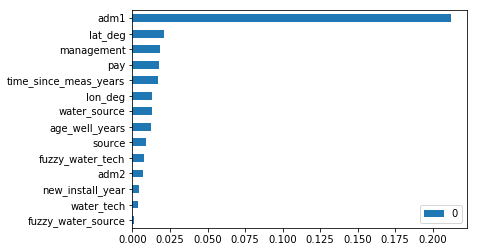

In [100]:
imp = permutation_importances(model_outer, X_test, y_test, metrics.log_loss)

pd.DataFrame(data=abs(imp), index=X_test.columns).sort_values(by=0).plot(kind='barh')

# Ensure that if a well is ever bad, all subsequent measurements are bad, too

In [29]:
def append_outyear_predictions(original_df, threshold, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob):
    sl = original_df.copy()
    #ensures if a well was ever bad, it is bad in the future
    sl['today_preds']=np.where(sl.status_binary==1,1,np.where(today_predprob[:,1]>threshold,1,0))
    sl['today_predprob']= today_predprob[:,1]
    sl['one_year_preds'] = np.where(np.max(sl[['status_binary','today_preds']], axis = 1)>0,
                                    1,np.where(one_year_predprob[:,1]>threshold,1,0))
    sl['one_year_predprob'] = one_year_predprob[:,1]
    sl['three_year_preds'] = np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds']], axis = 1)>0,1,
                                      np.where(three_year_predprob[:,1]>threshold,1,0))
    sl['three_year_predprob']= three_year_predprob[:,1]
    sl['five_year_preds']=np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds', 'three_year_preds']], axis = 1)>0,
                                   1,np.where(five_year_predprob[:,1]>threshold,1,0))
    sl['five_year_predprob'] =five_year_predprob[:,1]
    
    
    return sl

In [30]:
liberia = df.loc[df.country_name=='Liberia']

In [31]:
#liberia.groupby('installer').size()

In [116]:
#old results
coerced = append_outyear_predictions(liberia, 0.237, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [32]:
#new results with adjusted time to measure
coerced2 = append_outyear_predictions(liberia, 0.237, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [118]:
#old results
coerced[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,14028.000000,14028.000000,14028.000000,14028.000000,14028.000000
mean,0.257129,0.499287,0.559239,0.559239,0.559239
std,0.437066,0.500017,0.496496,0.496496,0.496496
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
#new results with adjusted time to measure
coerced2[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,14028.000000,14028.000000,14028.000000,14028.000000,14028.000000
mean,0.257129,0.499287,0.502139,0.506202,0.508483
std,0.437066,0.500017,0.500013,0.499979,0.499946
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
#num wells working at time of measuremen, predicted to work today, but not in one year
print(coerced2[coerced2.status_binary==0][(coerced2.today_preds<coerced2.one_year_preds)].shape)

(40, 48)


In [119]:
coerced.to_csv('Liberia_w_outyear_predictions_coerced.csv')

In [37]:
coerced2.to_csv('Liberia_w_outyear_predictions_coerced_correct_time2.csv')